In [1]:
using Revise
using TransportBasedInference
using HierarchicalDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations
using Distributions
using Statistics
using SparseArrays
using LinearMaps

Precompiling HierarchicalDA
  ✓ HierarchicalDA
  1 dependency successfully precompiled in 7 seconds. 499 already precompiled.


In [2]:
using CairoMakie
using LaTeXStrings
# using Plots

In [3]:
polydeg = 3
Ncells = 100

Nx = (polydeg+1)*Ncells
Δ = 20
Ny = ceil(Int64, Nx/Δ)

# Define Trixi system for inviscid Burgers equation
sys_burgers = setup_burgers(polydeg, Ncells);

xgrid = vec(sys_burgers.mesh.md.xq);

Define polynomial annihilator operator

In [4]:
order_PA = 3

Ns = Nx - 2*ceil(Int64, order_PA/2)

PA = PolyAnnil(xgrid, order_PA; istruncated = true)

@assert size(PA.P) == (Ns, Nx)

S = LinearMaps.FunctionMap{Float64,true}((s,x)->mul!(s, PA.P, x), (x,s)->mul!(x, PA.P', s),
Ns, Nx; issymmetric=false, isposdef=false)

xs = xgrid[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)]

396-element Vector{Float64}:
 -0.9866001895641519
 -0.9813886368840595
 -0.9786113631159403
 -0.9733998104358488
 -0.9666001895641518
 -0.9613886368840595
 -0.9586113631159403
 -0.9533998104358486
 -0.9466001895641517
 -0.9413886368840595
 -0.9386113631159403
 -0.9333998104358486
 -0.9266001895641518
  ⋮
  0.9333998104358489
  0.9386113631159406
  0.9413886368840593
  0.9466001895641516
  0.9533998104358488
  0.9586113631159405
  0.9613886368840594
  0.9666001895641515
  0.973399810435849
  0.9786113631159405
  0.9813886368840595
  0.9866001895641516

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.01
Δtobs = 0.01

0.01

Define the time span of interest

In [6]:
t0 = 0.0
Tf = 100
Tspin = 1000
tf = t0 + Tf*Δtobs

1.0

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 400
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [8]:
σx_true = 0.001#Δtobs*1.0
σx = 0.01#copy(σx_true)
@show σx


σy = 0.2

ϵx_true = AdditiveInflation(Nx, zeros(Nx), σx_true)
ϵx = AdditiveInflation(Nx, zeros(Nx), σx)

ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

σx = 0.01


AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04000000000000001 0.0 … 0.0 0.0; 0.0 0.04000000000000001 … 0.0 0.0; … ; 0.0 0.0 … 0.04000000000000001 0.0; 0.0 0.0 … 0.0 0.04000000000000001], [0.2 0.0 … 0.0 0.0; 0.0 0.2 … 0.0 0.0; … ; 0.0 0.0 … 0.2 0.0; 0.0 0.0 … 0.0 0.2])

Setup system for inviscid Burgers equation

In [9]:
h(x, t) = x[1:Δ:end]
H = LinearMap(sparse(Matrix(1.0*I, Nx, Nx)[1:Δ:end,:]))
F = StateSpace(x->x, h)

StateSpace(var"#5#6"(), TransportBasedInference.var"#27#28"(), h)

Define ObsConstraintSystem

In [10]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx_true, ϵy, π0, 0, 0, 0, F);

In [11]:
# Define function class for the initial condition
αk = 0.7
f0 = SmoothPeriodic(xgrid, αk; L = 2.0)

SmoothPeriodic(400, 2.0, 0.7, ComplexF64[0.43136820263182957 + 0.45536782650651464im, -0.3307581199610531 - 0.3952659555450546im, -0.3089965705690362 - 0.14434930218855851im, 0.0008653180086974632 + 0.08772218412741682im, 0.25631575182537764 + 0.4906277497805361im, -0.3176552252043835 + 0.01933296325934611im, 0.25599694189626077 + 0.10982190755940577im, 0.20301113686267927 + 0.16393848585984042im, -0.11328459934460983 + 0.001339459187378656im, -0.01140241300002599 + 0.012113043447844973im  …  -1.055206885076534e-14 - 3.2280556926463316e-15im, -8.552091697656776e-15 - 1.728928243762914e-15im, 2.926191763443851e-15 - 2.9727162167608726e-15im, -4.201669572046649e-15 - 1.7348766453460641e-15im, 1.0637999961192122e-14 + 1.6793859886927401e-15im, -3.8829364730825645e-15 - 4.393618596123169e-15im, -1.949370172381967e-15 + 1.6748202438572855e-15im, -2.83454346768666e-15 - 5.740704878442432e-15im, -6.060978724985676e-15 - 2.7268326957430746e-16im, -2.1196237978252975e-15 - 2.2974089814539793e-1

In [92]:
x0 = vec(1/2 .+ 0.5*sin.(3*π*sys_burgers.mesh.md.xq));
# x0 = f0.(xgrid);

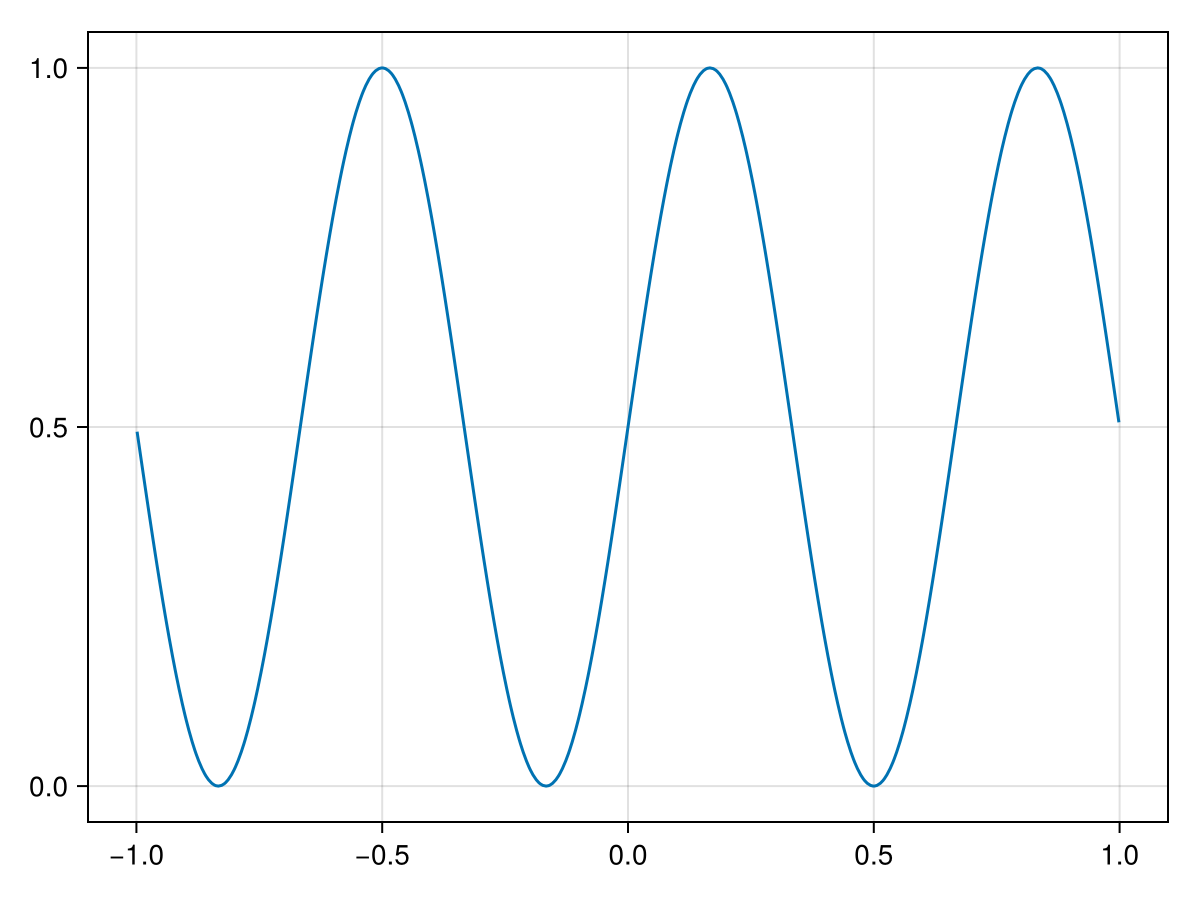

In [93]:
lines(xgrid, x0)

In [94]:
@time data = generate_data_trixi(model, x0, Tf, sys_burgers)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.171538 seconds (381.98 k allocations: 53.376 MiB)


SyntheticData([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1  …  0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0], 0.01, [0.4934563896573869, 0.4689173941833885, 0.4370225997681946, 0.4127450715138443, 0.39988966148727423, 0.3759585049420274, 0.34519359951990536, 0.3220375820269989, 0.3098693919682456, 0.2873938475030665  …  0.7126061524969327, 0.6901306080317535, 0.677962417973001, 0.6548064004800963, 0.6240414950579708, 0.6001103385127249, 0.5872549284861557, 0.5629774002318063, 0.5310826058166097, 0.5065436103426122], [0.5159948607682006 0.5448938577915011 … 0.36708006182283515 0.3617638793694585; 0.49367286281579725 0.5185558131320128 … 0.3717447612717486 0.3692464713317618; … ; 0.5583707920960521 0.5876179884510806 … 0.3625316532441544 0.36054870961369956; 0.5326526305043152 0.5603480574025101 … 0.36333008061367633 0.36445574758527616], [0.4153954182906274 0.38659572697574857 … 0.2560131118959204 0.595421974777072; 0.23464267990417

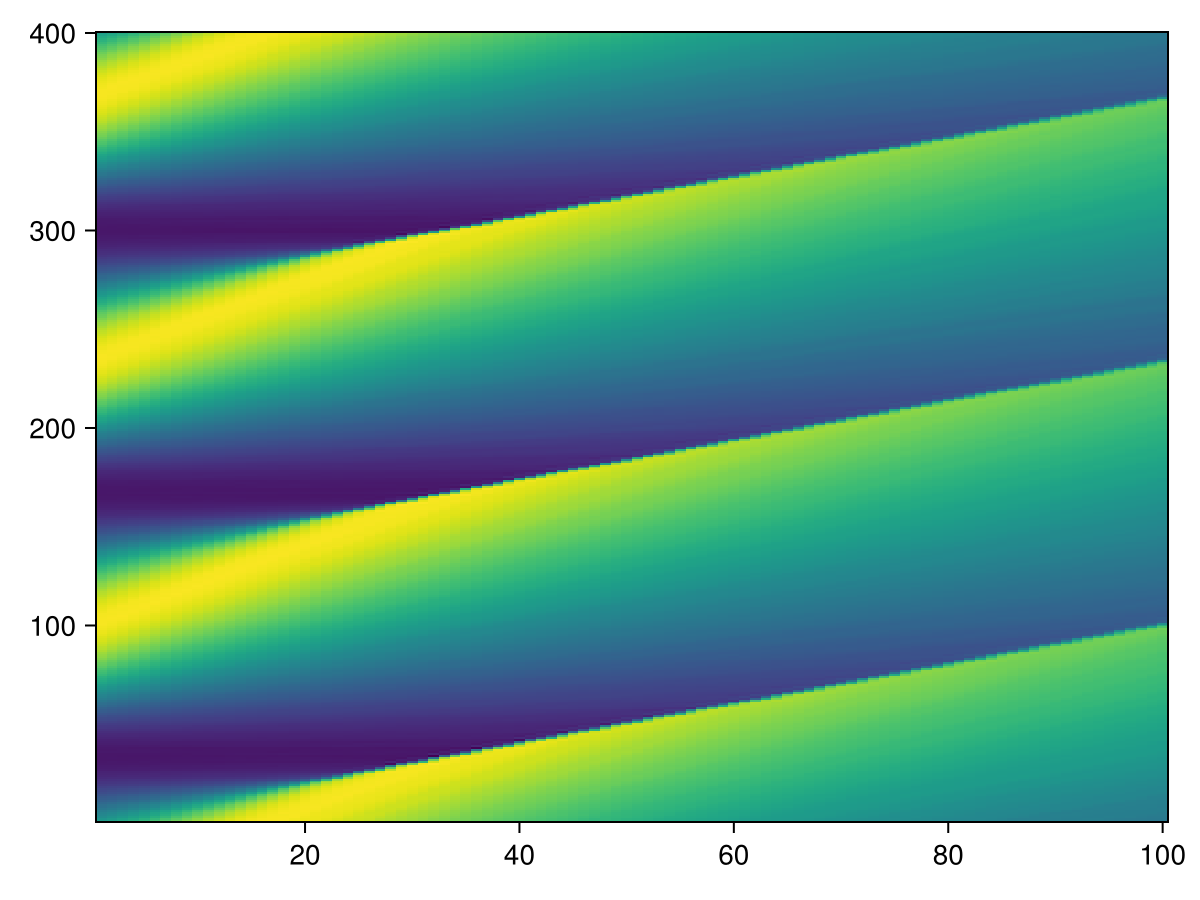

In [95]:
heatmap(data.xt[:, 1:end]')

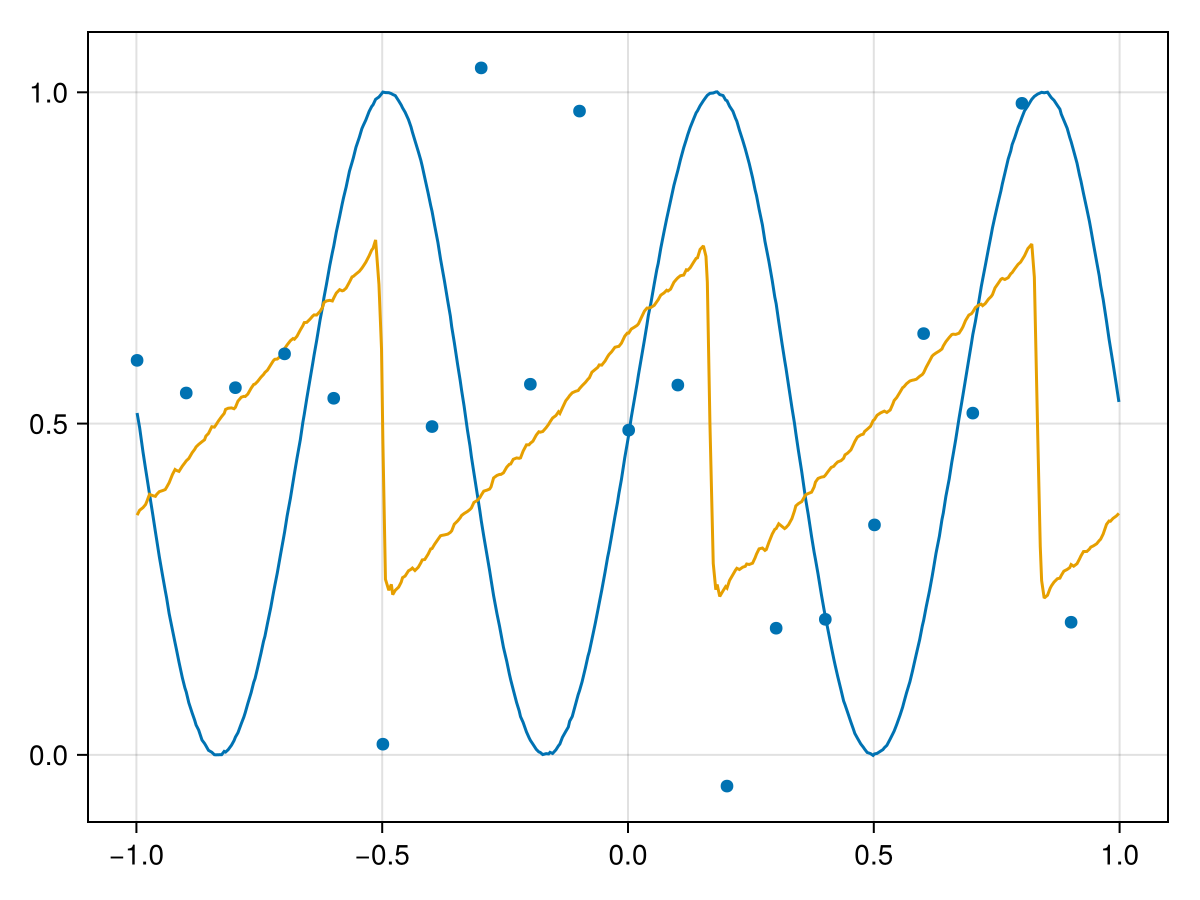

In [96]:
fig = Figure()
ax = Axis(fig[1,1])

lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xgrid, data.xt[:,100])
scatter!(ax, xgrid[1:Δ:end], data.yt[:,100])

fig

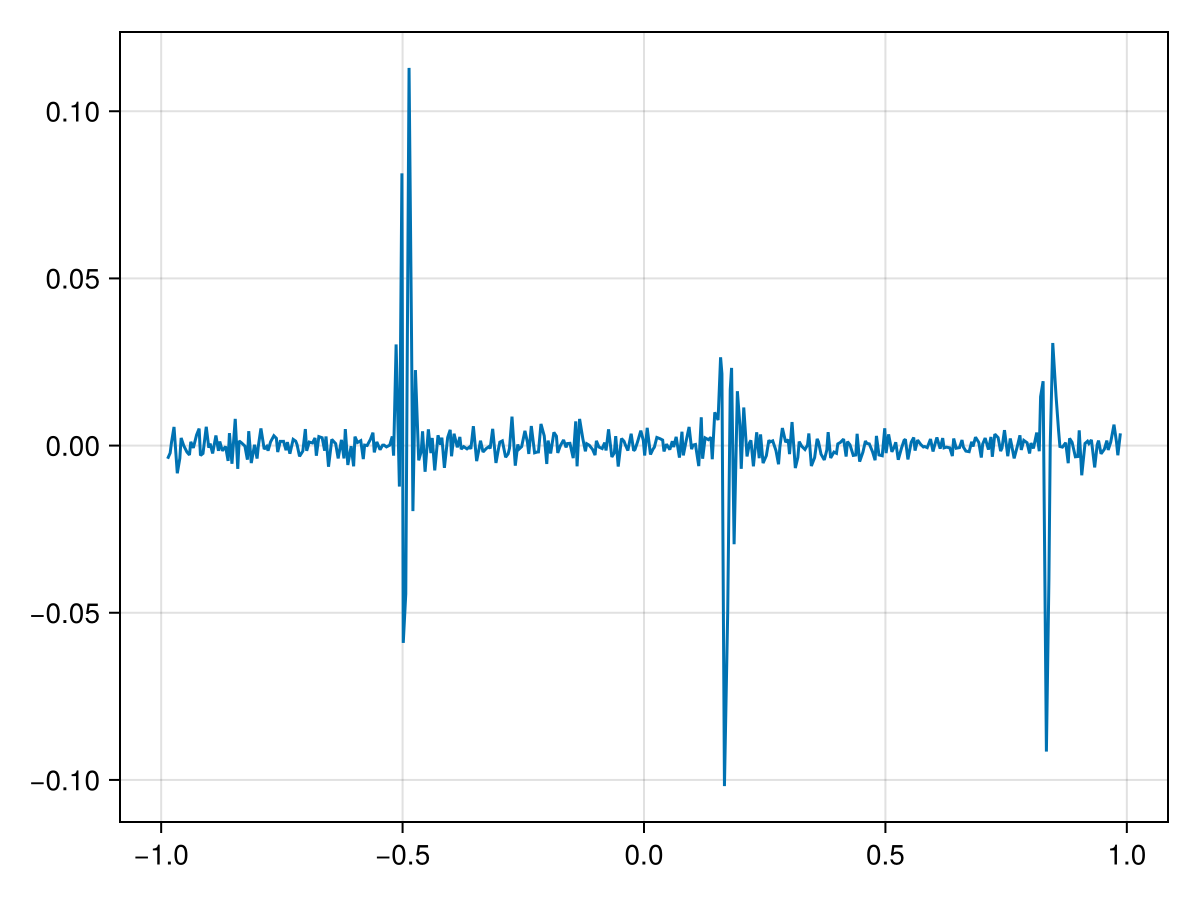

In [97]:
fig = Figure()
ax = Axis(fig[1,1])

# lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xs, PA*data.xt[:,100])

fig

Define ObsConstraintSystem

In [98]:
idx = 4

## Selecion of hyper-prior parameters
# power parameter
r_range = [ 1.0, .5, -.5, -1.0 ]; 
r = r_range[idx] # select parameter 
# shape parameter
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
β = β_range[idx] # shape parameter
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 
ϑ = ϑ_range[idx]

# r = -0.5
# β = 0.5
# ϑ = 0.01
dist = GeneralizedGamma(r, β, ϑ);

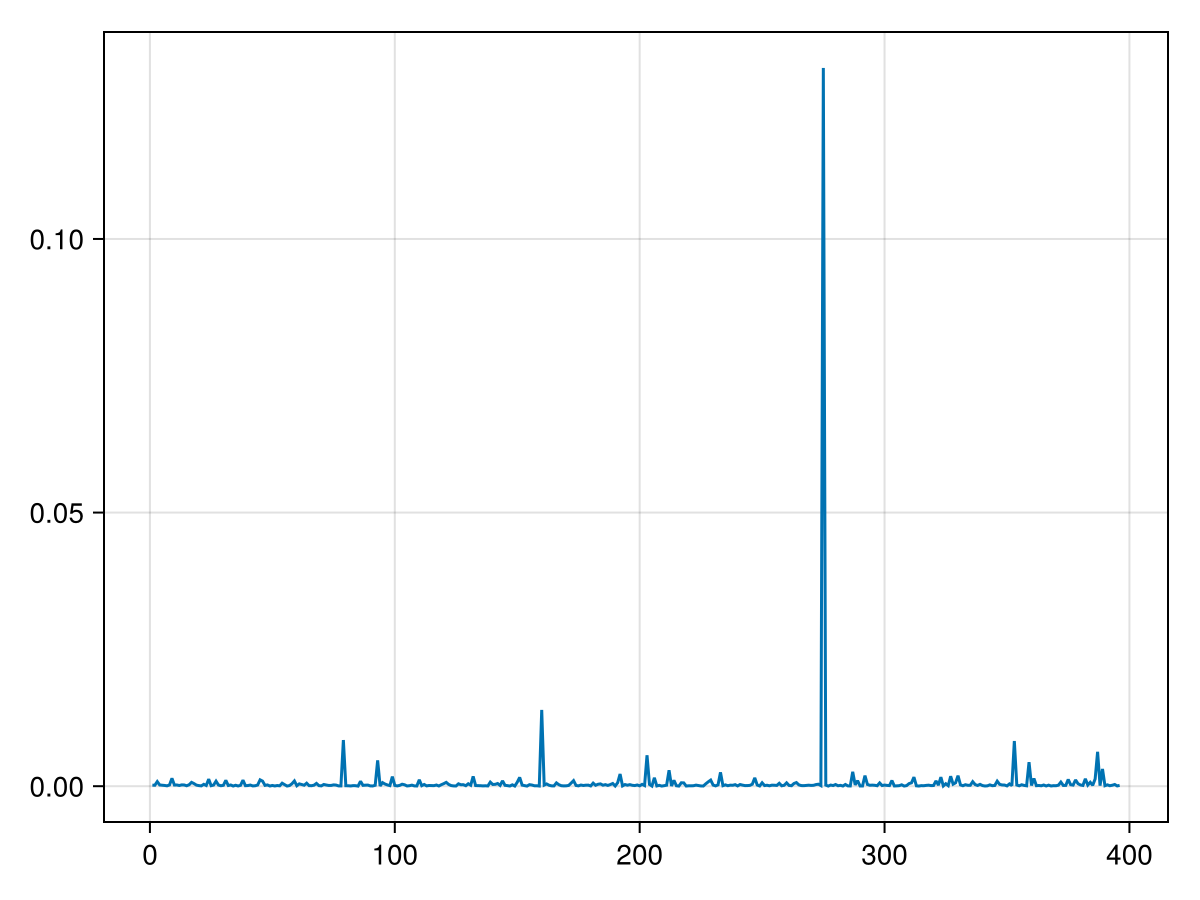

In [99]:
fig = Figure()

lines(rand(dist, Ns))

Create initial ensemble

In [100]:
Ne = 100
X = zeros(model.Ny + model.Nx, Ne)

for i=1:Ne
    regenerate!(f0)
    X[Ny+1:Ny+Nx,i] = f0.(xgrid)#initial_condition(αk, Δx, Nx)
end

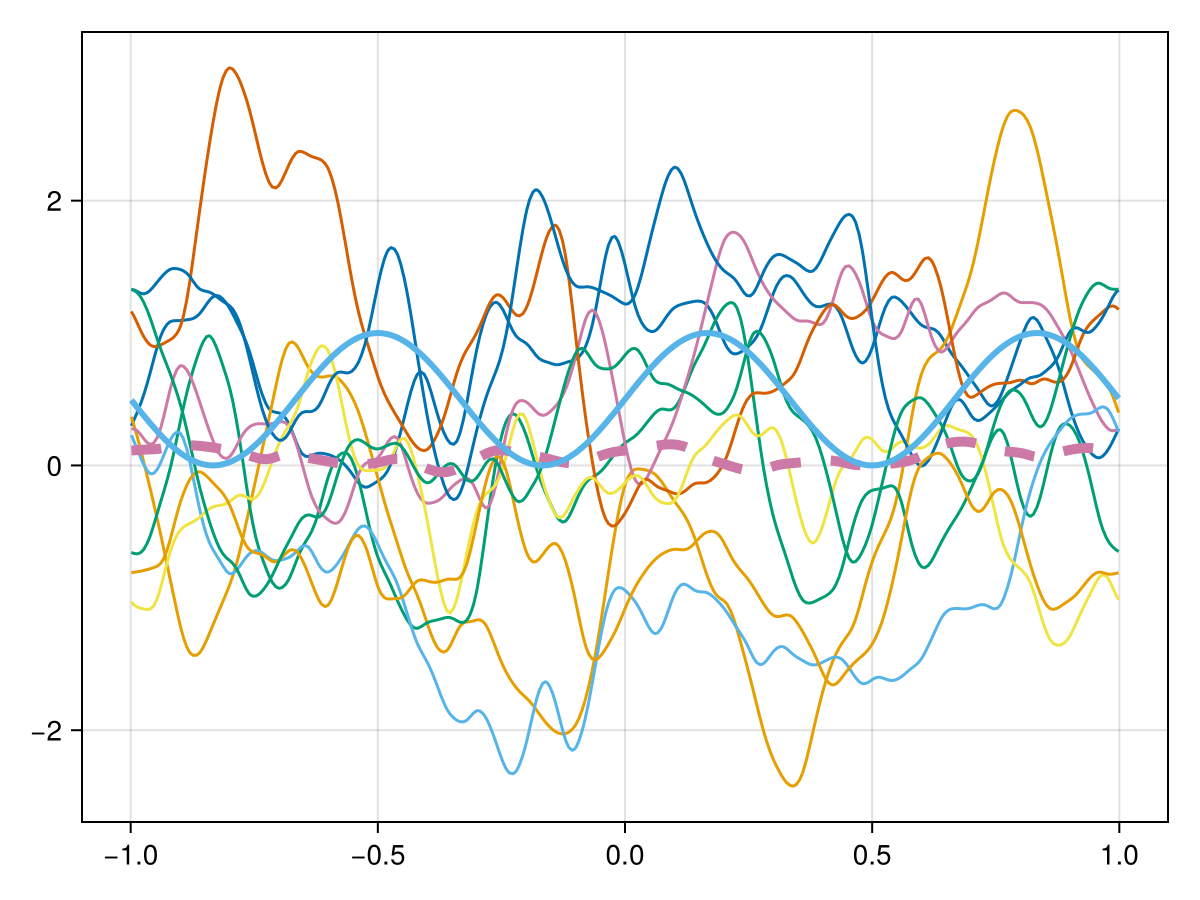

In [101]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:10
    lines!(ax, xgrid, X[Ny+1:Ny+Nx,i])
end
lines!(xgrid, mean(X[Ny+1:Ny+Nx,:]; dims = 2)[:,1], linewidth = 5, linestyle = :dash)

lines!(ax, xgrid, x0, linewidth = 3)

fig

Define initial guess

In [102]:
θinit = rand(dist, Ns);

Define linear maps and ObsConstraintSystem

In [103]:
Cθ = LinearMap(Diagonal(deepcopy(θinit)))
Cϵ = LinearMap(ϵy.Σ)
CX = LinearMap(Diagonal(1.0 .+ rand(Nx)))
sys_ys = ObsConstraintSystem(H, S, Cθ, Cϵ, CX)

ObsConstraintSystem(400, 20, 396, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 396×400 LinearMaps.FunctionMap{Float64,true}(#1, #2; issymmetric=false, ishermitian=false, isposdef=false), 396×396 LinearMaps.WrappedMap{Float64} of
  396×396 Diagonal{Float64, Vector{Float64}}, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [104]:
sys_y = ObsSystem(H, Cϵ, CX)

ObsSystem(400, 20, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [105]:
yidx = 1:Δ:Nx
idx = vcat(collect(1:length(yidx))', collect(yidx)')

# @assert length(yidx) == Ny

# # Create Localization structure
Gxx(i,j) = periodicmetric!(i,j, Nx)
Gxy(i,j) = periodicmetric!(i,yidx[j], Nx)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], Nx)

Lrad = 7
Loc = Localization(Lrad, Gxx, Gxy, Gxx)

Localization(7.0, Gxx, Gxy, Gxx)

In [106]:
β = 1.01
ϵxβ = MultiAddInflation(Nx, β, zeros(Nx), σx)

MultiAddInflation(400, 1.01, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

Define EnKF

In [107]:
enkf = EnKF(Ne, ϵy, sys_y, Δtdyn, Δtobs)

Matrix-free implementation of the ensemble Kalman filter with filtered = false


Define localized EnKF

In [108]:
locenkf = LocEnKF(Ne, ϵy, sys_y, Loc, Δtdyn, Δtobs)

Localized ensemble Kalman filter with filtered = false


Define hierarchical EnKF

In [109]:
henkf = HEnKF(Ne, ϵy, sys_ys, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical ensemble Kalman filter with filtered = false


Define hierarchical and localized EnKF

In [110]:
hlocenkf = HLocEnKF(Ne, ϵy, sys_ys, Loc, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical localized ensemble Kalman filter with filtered = false


In [111]:
X_enkf = seqassim_trixi(data, Tf, ϵxβ, enkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


In [112]:
X_locenkf = seqassim_trixi(data, Tf, ϵxβ, locenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


In [113]:
# X_henkf, θ_henkf = seqassim_trixi(data, Tf, ϵxβ, henkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

In [114]:
X_hlocenkf, θ_hlocenkf = seqassim_trixi(data, Tf, ϵxβ, hlocenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:06:17


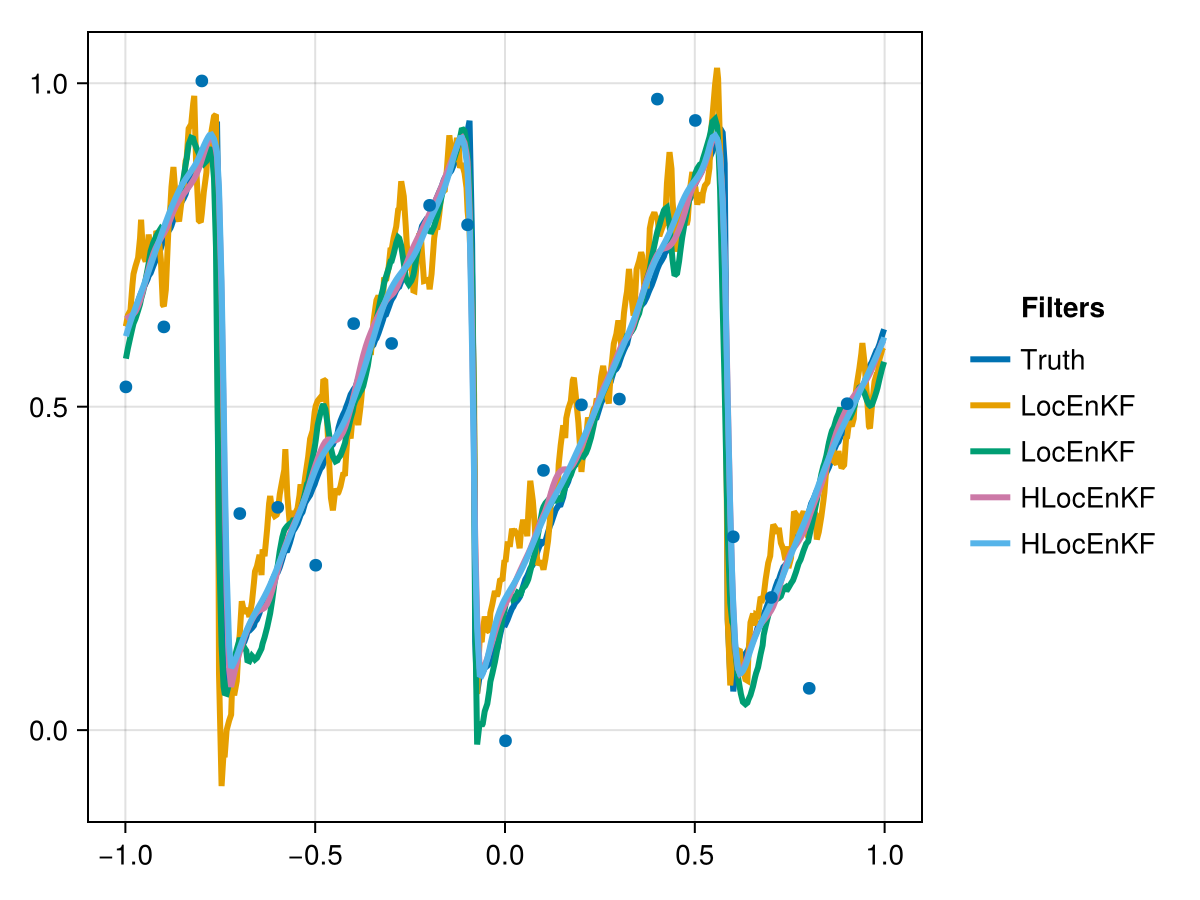

In [118]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 50
idx = 10

lines!(ax, xgrid, data.xt[:,tsnap], linewidth = 3, label = "Truth")

# lines!(ax, xgrid, X[Ny+1:Ny+Nx,2])
# lines!(ax, xgrid, X_enkf[tsnap+1][:,idx], linewidth = 3, label = "EnKF")
# lines!(ax, xgrid, mean(X_enkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "EnKF")

lines!(ax, xgrid, X_locenkf[tsnap+1][:,idx], linewidth = 3, label = "LocEnKF")
lines!(ax, xgrid, mean(X_locenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "LocEnKF")


# lines!(ax, xgrid, X_henkf[tsnap+1][:,2], linewidth = 3, label = "HEnKF")
# lines!(ax, xgrid, X_henkf[tsnap+1][:,2])
# lines!(ax, xgrid, mean(X_henkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HEnKF")

lines!(ax, xgrid, X_hlocenkf[tsnap+1][:,idx], linewidth = 3, label = "HLocEnKF")
lines!(ax, xgrid, mean(X_hlocenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HLocEnKF")

# ax2 = Axis(fig[1,2])

fig[1, 2] = Legend(fig, ax, "Filters", framevisible = false)

# lines!(ax, xgrid[1:2:end], data.yt[:,tsnap], linewidth = 3)


scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])
# lines!(ax, xs, PA.P*X_enkf[tsnap+1][:,2])


fig

In [123]:
data.xt

400×100 Matrix{Float64}:
 0.515995  0.544894  0.575407  0.608129  …  0.37197   0.36708   0.361764
 0.493673  0.518556  0.547457  0.578094     0.372404  0.371745  0.369246
 0.457117  0.482373  0.507634  0.539239     0.384116  0.376572  0.373187
 0.431792  0.453922  0.481222  0.507859     0.389927  0.383768  0.377769
 0.418846  0.439307  0.462516  0.491273     0.391623  0.391379  0.382736
 0.393996  0.412426  0.434752  0.461051  …  0.393424  0.39192   0.393275
 0.362158  0.380461  0.398929  0.420701     0.39502   0.392016  0.391209
 0.336911  0.352532  0.372262  0.393495     0.397725  0.396009  0.390204
 0.323859  0.341456  0.357615  0.377317     0.398467  0.397756  0.393285
 0.299053  0.312999  0.328193  0.346281     0.399487  0.39962   0.397284
 0.269888  0.280693  0.293879  0.307973  …  0.402642  0.400754  0.398932
 0.248132  0.25889   0.269855  0.281653     0.413437  0.405554  0.40044
 0.237185  0.245795  0.255854  0.2711       0.419304  0.407561  0.403819
 ⋮                         

In [116]:
rmse_locenkf = mean(map(i->norm(data.xt[:,i]-mean(X_locenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.08542107504536527

In [121]:
spread_locenkf = mean(map(i->spread(X_locenkf[i+1]), 1:Tf))

0.14639207895496115

In [117]:
rmse_hlocenkf = mean(map(i->norm(data.xt[:,i]-mean(X_hlocenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.050592092193727456

In [122]:
spread_hlocenkf = mean(map(i->spread(X_hlocenkf[i+1]), 1:Tf))

0.014276695046335209

In [70]:
?@lift

Replaces an expression with `lift(argtuple -> expression, args...)`, where `args` are all expressions inside the main one that begin with $.

# Example:

```julia
x = Observable(rand(100))
y = Observable(rand(100))
```

## before

```julia
z = lift((x, y) -> x .+ y, x, y)
```

## after

```julia
z = @lift($x .+ $y)
```

You can also use parentheses around an expression if that expression evaluates to an observable.

```julia
nt = (x = Observable(1), y = Observable(2))
@lift($(nt.x) + $(nt.y))
```


In [85]:
tsnap = Observable(1)

x_tsnap = @lift(hcat(data.x0, data.xt)[:,$(tsnap)])
y_tsnap = @lift(hcat(zeros(Ny), data.yt)[:,$(tsnap)])
X_locenkf_tsnap = @lift(mean(X_locenkf[$tsnap]; dims = 2)[:,1])
X_hlocenkf_tsnap = @lift(mean(X_hlocenkf[$tsnap]; dims = 2)[:,1])

scaled_θ_hlocenkf_tsnap = @lift(θ_hlocenkf[$tsnap] / norm(θ_hlocenkf[$tsnap]))


fig = Figure()

ax1 = Axis(fig[1,1])

lines!(ax1, xgrid, x_tsnap, linewidth = 3, label = "Truth")
lines!(ax1, xgrid, X_locenkf_tsnap, linewidth = 3, label = "LocEnKF")
lines!(ax1, xgrid, X_hlocenkf_tsnap, linewidth = 3, label = "HLocEnKF", linestyle =:dashdot)
scatter!(ax1, xgrid[1:Δ:end], y_tsnap, color = :grey)

axislegend(ax1)

ax2 = Axis(fig[1,2])

lines!(ax2, xs, scaled_θ_hlocenkf_tsnap, linewidth = 3, label = L"θ")
ylims!(ax2, 0.0, 0.6)

framerate = 10
timestamps = range(1, 101, step = 1)

record(fig, "inviscid_burgers.mp4", timestamps; framerate = framerate) do t
    tsnap[] = t
end

"inviscid_burgers.mp4"

In [ ]:
time = Observable(0.0)

x1i = @lift(vcat(map(i->sim.u[i]($time)[1], 1:Ne)...))
x2i = @lift(vcat(map(i->sim.u[i]($time)[2], 1:Ne)...))

idx_color_tab = zeros(Int64, Ne)

for i=1:Ne
    x0i = sim.u[i](0.0)
    idx_color_tab[i] = ceil(Int64, phase_coloring(x0i, ColorSchemes.phase))
end


fig, axis, scatterplot = scatter(x1i, x2i, markersize = 20, color = ColorSchemes.phase[idx_color_tab], 
            fontsize = 20, 
            axis = (
            aspect = 1.0,
            title = @lift("t = $(round($time, digits = 1))"),
#             title =  @lift("t = $(time"),
            xlabel = L"x_1", 
            ylabel = L"x_2"))

CairoMakie.xlims!(axis, [-5.0, 5.0])
CairoMakie.ylims!(axis, [-5.0, 5.0])

framerate = 30
timestamps = range(0, tf, step=1/framerate)

record(fig, "spiral2D_animation.mp4", timestamps; framerate = framerate) do t
    time[] = t
end

In [90]:
mean(std(X_hlocenkf[50]; dims = 2))

0.009676578648979434

In [91]:
mean(std(X_locenkf[50]; dims = 2))

0.10739266217946707

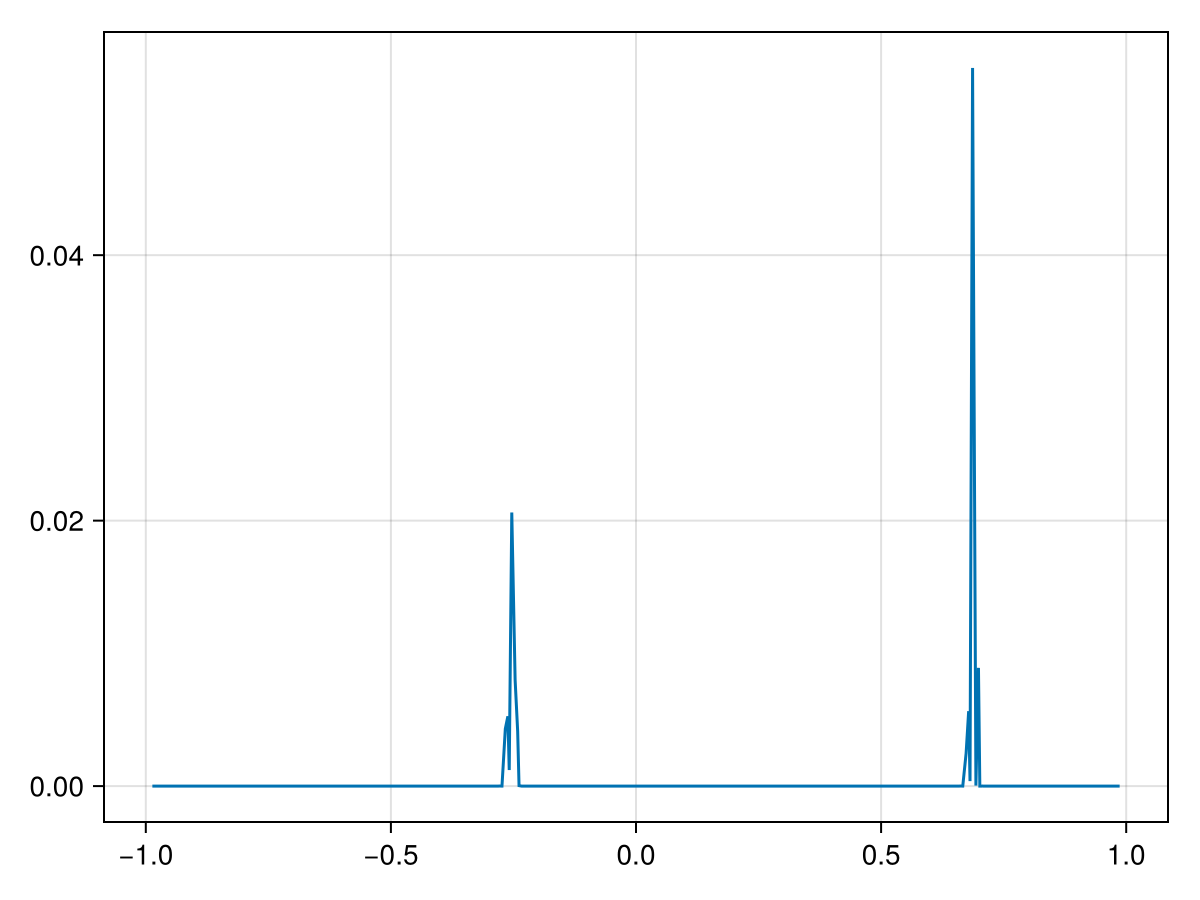

In [73]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 80

# lines!(ax, xs, θ_henkf[tsnap])
lines!(ax, xs, θ_hlocenkf[tsnap])


fig